In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Functions
---
#### generate_phi(data, K): Function to generate Phi with K features.
 K features = The sunspot values from the last K months. (Last month = position 0)
 
#### generate_y(data, K)
 Get the labels from K to lenght of the data
 
#### predict_x_next(train_subset, w, X, K):
  Predict X next sunspot values
  train_subset = last K values from the train set
  w = Weights
  X = number of predictions


In [2]:
def generate_phi(data, K):
    phi = []
    for i in range(len(data) - K):
        phi_x = np.insert(np.flip(data[i:i + K]), 0, 1)
        phi.append(phi_x)
    return np.array(phi)

def generate_y(data, K):
    y = []
    for i in range(K, len(data)):
        y.append(data[i])
    return y

In [3]:
def predict_x_next(train_subset, w, X, K):
    predicted_values = []
    for i in range(X):
        features = np.insert(np.flip(train_subset[i:]), 0, 1).T
        predicted_value = np.dot(features, w)
        train_subset = np.append(train_subset, predicted_value)
        predicted_values.append(predicted_value)
        
    return predicted_values

In [4]:
def k_fold(x, y, k):
    
    if len(x) != len(y):
        print('X and Y must have the same shape.')
        print('X have shape of {} and Y have shape {}'.format(x.shape, y.shape))
        return None
    
    elements_per_fold = len(x) / k
    
    x_folds, y_folds = [], []
    for i in range(k):
        x_fold = x[i * elements_per_fold: (i+1) * elements_per_fold]
        y_fold = y[i * elements_per_fold: (i+1) * elements_per_fold]
        x_folds.append(x_fold)
        y_folds.append(y_fold)
    
    return x_folds, y_folds

In [5]:
def compute_error_k_fold(x, y):
    rmse = lambda predictions, sunspots_values_test: np.sqrt(np.sum(predictions - sunspots_values_test)**2) * 1/len(predictions)
    error_hist, w_hist = [], []
    folds_number = len(x)
    
    for validation_index in range(folds_number):
        
        x_train, y_train, x_validation, y_validation = [], [], [], []
        
        for train_index in range(folds_number):
            
            if validation_index == train_index:
                x_validation = x[validation_index]
                y_validation = y[validation_index]
                continue
            
            try:
                x_train = np.append(x_train, x[train_index], axis=0)
            except:
                x_train = np.array(x[train_index])
            
            y_train += y[train_index]
        
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        
        w = np.dot(np.dot(np.linalg.inv(np.dot(x_train.T, x_train)), x_train.T), y_train)
        
        predictions = np.dot(x_validation, w)
        
        error = rmse(predictions, y_validation)
        error_hist.append(error)
        w_hist.append(w)
    
    return error_hist, w_hist, np.min(error_hist), np.std(error_hist)
        

In [6]:
def remove_features(x, idx):
    if idx == 0:
        print("You can't remove the bias from Phi")
        return None
    
    phi_without_idx = []
    for phi in x:
        phi_without_idx.append(np.delete(phi, idx))
    
    return phi_without_idx
        

In [7]:
df = pd.read_csv('../data/sunspot.txt', delimiter=r"\s+", names=['Year','Jan', 'Feb', 'Mar', 'Apl', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
df.head()

,Year,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1749,58.0,62.6,70.0,55.7,85.0,83.5,94.8,66.3,75.9,75.5,158.6,85.2
1,1750,73.3,75.9,89.2,88.3,90.0,100.0,85.4,103.0,91.2,65.7,63.3,75.4
2,1751,70.0,43.5,45.3,56.4,60.7,50.7,66.3,59.8,23.5,23.2,28.5,44.0
3,1752,35.0,50.0,71.0,59.3,59.7,39.6,78.4,29.3,27.1,46.6,37.6,40.0
4,1753,44.0,32.0,45.7,38.0,36.0,31.7,22.0,39.0,28.0,25.0,20.0,6.7


In [8]:
matrix = df.values
_df_matrix = []
for row in matrix:
    for i in range(1,13):
        entry = [int(row[0]), row[i]]
        _df_matrix.append(entry)

_df_matrix = np.array(_df_matrix)

_df = pd.DataFrame(_df_matrix)

_df.columns = ['year', 'value']


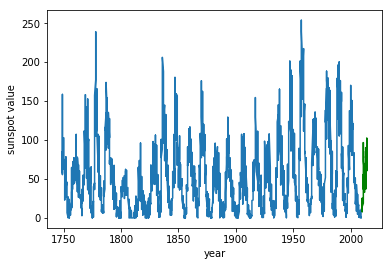

In [9]:
# Test set: 5 recent years [2010 ~ 2014]
# 5 * 12 = 60
# Last 60 rows

years_test = _df_matrix[-60:,0]
sunspots_values_test = _df_matrix[-60:,1]

years_train = _df_matrix[:-60,0]
sunspots_values_train = _df_matrix[:-60,1]

plt.plot(years_train, sunspots_values_train)
plt.plot(years_test, sunspots_values_test, 'g')
plt.xlabel('year')
plt.ylabel('sunspot value')
plt.show()

In [10]:
phi = generate_phi(_df.values[:-60,1], 20)

y = generate_y(_df.values[:-60,1], 20)

w = np.dot(np.dot(np.linalg.inv(np.dot(phi.T, phi)), phi.T), y)


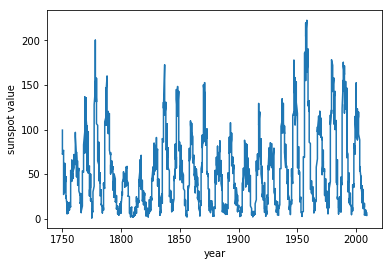

In [11]:
plt.plot(years_train[20:], np.dot(phi,w) )
plt.xlabel('year')
plt.ylabel('sunspot value')
plt.show()

In [12]:
last_train_subset = sunspots_values_train[-20:]

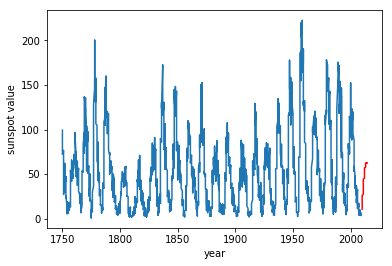

In [13]:
predictions = predict_x_next(last_train_subset, w, 60, 20)

plt.plot(years_train[20:], np.dot(phi,w) )
plt.plot(years_test, predictions, 'r' )
plt.xlabel('year')
plt.ylabel('sunspot value')
plt.show()

3132


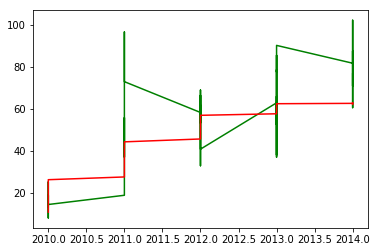

In [14]:
plt.plot(years_test, sunspots_values_test, 'g')
plt.plot(years_test, predictions, 'r')
#sunspots_values_test
print(len(sunspots_values_train))

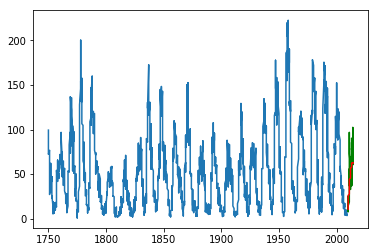

In [15]:
plt.plot(years_train[20:], np.dot(phi,w) )
plt.plot(years_test, sunspots_values_test, 'g')
plt.plot(years_test, predictions, 'r')

In [16]:
rmse = lambda predictions, sunspots_values_test: np.sqrt(np.sum(predictions - sunspots_values_test)**2) * 1/len(predictions)

rmse(predictions, sunspots_values_test)

8.900682833206169

## K-Fold

In [17]:
x_fold, y_fold = k_fold(phi, y, 10)


## Wrapper - Backward elimination

In [18]:
error_hist, w_hist, min_error, error_std = compute_error_k_fold(x_fold, y_fold)
min_error_all_features = min_error

### Backward elimination

In [20]:
print("Error with all features: {}\t\tStd: {}".format(min_error_all_features, error_std))
print('==='*25)

number_total_features = 21

converged = False
phi_iter = phi
last_error = min_error_all_features
while not converged:
    min_error_hist = []
    std_hist = []
    for i in range(1,number_total_features):
        phi_updated = remove_features(phi_iter, i)

        x_fold, y_fold = k_fold(phi_updated, y, 10)
        error_hist, w_hist, min_error, error_std = compute_error_k_fold(x_fold, y_fold)

        print("Removing feature #{} \t Min error: {}\tStd: {} ".format(i, min_error, error_std))
        min_error_hist.append(min_error)
        std_hist.append(error_std)

    
    index_to_remove = np.argmin(min_error_hist) + 1
    print('==='*25)
    print('Feature #{} was choosed.\tMin error: {}\tStd: {}'.format(index_to_remove, min_error_hist[index_to_remove-1], std_hist[index_to_remove -1]))
    
    if last_error >= min_error_hist[index_to_remove - 1]:    
        last_error = min_error_hist[index_to_remove - 1]
        number_total_features -= 1
        phi_updated = remove_features(phi_iter, index_to_remove)
    
    else:
        converged = True
        print ('Algorithm converged.')
    print('==='*25)
    
    


Error with all features: 0.181370640177		Std: 0.63888494716
Removing feature #1 	 Min error: 0.262651639174	Std: 0.970938151594 
Removing feature #2 	 Min error: 0.188792925559	Std: 0.65992008789 
Removing feature #3 	 Min error: 0.190457675528	Std: 0.651414806127 
Removing feature #4 	 Min error: 0.188280419428	Std: 0.643277111648 
Removing feature #5 	 Min error: 0.18393196065	Std: 0.641657974242 
Removing feature #6 	 Min error: 0.186772881916	Std: 0.639487913722 
Removing feature #7 	 Min error: 0.181404399155	Std: 0.640195843358 
Removing feature #8 	 Min error: 0.183539866373	Std: 0.639187552011 
Removing feature #9 	 Min error: 0.182104563535	Std: 0.634080915084 
Removing feature #10 	 Min error: 0.18163427436	Std: 0.639707737877 
Removing feature #11 	 Min error: 0.180905784785	Std: 0.638536480386 
Removing feature #12 	 Min error: 0.181291697105	Std: 0.640758594337 
Removing feature #13 	 Min error: 0.18193872569	Std: 0.642410166326 
Removing feature #14 	 Min error: 0.1812549